### Import library

In [1]:
""" Example 2 is inbalanced data set; ~2200 in PD and ~1100 in SNP
    Goal is to predict if mutation is SNP or PD
    improve_MCC branch
    
    Total samples: 3368
    2254 PD samples
    1111 SNP samples
    3 NA samples
"""

' Example 2 is inbalanced data set; ~2200 in PD and ~1100 in SNP\n    Goal is to predict if mutation is SNP or PD\n    improve_MCC branch\n    \n    Total samples: 3368\n    2254 PD samples\n    1111 SNP samples\n    3 NA samples\n'

In [2]:
""" Imports the required libraries and packages """

import pandas as pd                                                              # Data manipulation in dataframes
import numpy as np                                                               # Array manipulation
from numpy import random

import random as rd                                                              # Random seed generation
import time                                                                      # Time program run time
import sys

import matplotlib.pyplot as plt
from matplotlib.patches import Patch                                             # CV visualise
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

from sklearn.metrics import(
    matthews_corrcoef,                                                           # MCC for evaluation
    # balanced_accuracy_score, #hyperparameter evaluation
    # f1_score,  #hyperparameter evaluation
    confusion_matrix,                                                            # Confusion matrix for classification evalutation
    classification_report                                                        # Return the F1, precision, and recall of a prediction
    )

from sklearn.model_selection import(
    train_test_split,                                                            # Splits data frame into the training set and testing set
    # GridSearchCV,  # Searches all hyperparameters
    # RandomizedSearchCV, # Searches random range of hyperparameters
    GroupKFold                                                                   # K-fold CV with as groups
        )

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier                              # SK learn API for classificastion random forests

np.set_printoptions(precision = 3,threshold=np.inf, suppress=True)               # Full array printing

### Split dataset into training and validation sets

In [3]:
def Train_Test_Split(file):
    """      
    Input:      file             Pre-processed dataset done by PDB2AC script

    Returns:    Training_Set     80% training set split
                Testing_Set      20% testing set split
                
    80% training and 20% testing split. Splits are shuffled randomly and index reset
    """
    AC_dataset                  = pd.read_csv(file)    
    Training_Set, Testing_Set   = train_test_split(AC_dataset,train_size = 0.8)
    
    Training_Set.reset_index(drop=True, inplace = True) #Drop index to avoid training on index values
    Testing_Set.reset_index(drop=True, inplace = True)  #Reset index after splitting for compatability with CV()
        
    Training_Set                = Training_Set.sample(frac = 1) #Shuffle data after splitting
    Testing_Set                 = Testing_Set.sample(frac = 1)
    
    return Training_Set, Testing_Set

### Initial evaluation

In [4]:
def test(Training_Set, Testing_Set):
    """ 
    Input:  Training_Set   Training data
            Testing_Set    Testing data

    Evaluate training data before CV and balancing. Random forest classifier for prediction on the test data. 
    True values are testing data class labels
    """
    Initial_train  = Training_Set.drop(['dataset_pd','AC Code'], axis=1, inplace = False)
    labels_train   = Training_Set['dataset_pd'].astype('int32')

    
    Initial_test   = Testing_Set.drop(['dataset_pd','AC Code'],axis=1, inplace = False)
    labels_test    = Testing_Set['dataset_pd'].astype('int32')
    
    RFC_initial    = RandomForestClassifier()
    RFC_initial.fit(Initial_train, labels_train)

    Output_pred    = RFC_initial.predict(Initial_test)
    
    print(f"              **Initial Evaluation**")
    print(f"Confusion Matrix:\n {confusion_matrix(labels_test, Output_pred)}")
    print(f"MCC              {matthews_corrcoef(labels_test, Output_pred)}\n")


## Group K-fold CV (outer loop)

In [5]:
def CV(Training_Set):
    """      
    Input:      Training_Set     80% training set split
            
    Returns:    IT_list         List of training features for each fold
                LT_list         List of training class labels for each fold
                IV_list         List of validation features for each fold
                LV_list         List of validation class labels for each fold

    Group K-fold CV with protein groups separated between training and validation sets for each fold. Creates 5 folds.
    """
    
    Input_CV       = Training_Set.drop(['dataset_pd'], axis =1)         #Features for training
    Output_CV      = Training_Set['dataset_pd'].copy().astype('int32')  #Class labels for training
    Protein_Groups = Training_Set['AC Code'].to_list()                  #List of proteins for grouping
        
    CV             = GroupKFold(n_splits = 5)                           #Creates 5 splits
    
    IT_list = []
    LT_list = []
    IV_list = []
    LV_list = []
    
    for train_idx, val_idx in CV.split(Input_CV, Output_CV, Protein_Groups): #Generates the indices to be used for a training and validation split. Indicies are unique to train/ val sets
                               
        Input_train                        = Input_CV.loc[train_idx]         #New dataframe from selected indices
        Classes_train                      = Output_CV.loc[train_idx]
        Input_train.drop(['AC Code'], axis = 1, inplace = True)              #Group identifer not needed for training
                
        Input_val                          = Input_CV.loc[val_idx]
        Classes_val                        = Output_CV.loc[val_idx]
        Input_val.drop(['AC Code'], axis   = 1, inplace = True)

        IT_list.append(Input_train)       
        LT_list.append(Classes_train)
        IV_list.append(Input_val)
        LV_list.append(Classes_val)
        

    return(IT_list, LT_list, IV_list, LV_list)


### CV visualize

In [13]:
def viz(Training_Set):
    rng = np.random.RandomState(1338)
    
    n_points = len(Training_Set)
    
    X = range(len(Training_Set))
    y = np.stack(Training_Set['dataset_pd'])
    groups = np.stack(set(Training_Set['AC Code']))

    def visualize_groups(classes, groups):
        # Visualize dataset groups
        fig, ax = plt.subplots()
        ax.scatter(
            range(len(groups)),
            [0.5] * len(groups),
            c=groups,
            marker="_",
            lw=50,
            cmap=cmap_data,
        )
        ax.scatter(
            range(len(groups)),
            [3.5] * len(groups),
            c=classes,
            marker="_",
            lw=50,
            cmap=cmap_data,
        )
        ax.set(
            ylim=[-1, 5],
            yticks=[0.5, 3.5],
            yticklabels=["Data\ngroup", "Data\nclass"],
            xlabel="Sample index",
        )
        
    visualize_groups(y, groups)

c:\Users\shami\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3433: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['P01009' 'Q9H816' 'P42892' 'P03950' 'P08253' 'Q3U046' 'Q9UKU7' 'P15559'
 'P00491' 'P21549' 'B2RDU6' 'P40394' 'Q16555' 'Q16790' 'P55210' 'P23467'
 'P30793' 'E7ER61' 'Q6VVX0' 'P78504' 'P01042' 'Q8N4Q0' 'P05062' 'P17066'
 'Q92854' 'P60174' 'O75608' 'Q15256' 'Q5SZC1' 'Q01415' 'Q6MZZ7' 'P27361'
 'P49418' 'Q5FWE9' 'P55212' 'P16219' 'P32322' 'P07998' 'P17931' 'P30622'
 'P02730' 'Q03013' 'P01112' 'Q68CZ1' 'O60678' 'P43403' 'Q9P0N9' 'Q5TD97'
 'P26440' 'Q6ZNL6' 'P10635' 'Q13614' 'Q9UNF0' 'P55008' 'P53634' 'P19878'
 'P23141' 'P09326' 'O43307' 'Q10471' 'Q93099' 'P07949' 'P45954' 'P07996'
 'P62825' 'P35557' 'P00995' 'Q99616' 'P12271' 'P23526' 'Q15257' 'P05543'
 'P41159' 'Q96FI4' 'Q9UQN3' 'O00391' 'P51659' 'O75396' 'P11473' 'O15392'
 'O75563' 'Q01196' 'P36551' 'Q9GZV9' 'Q13651' 'Q9H2H8' 'P06870' 'P61769'
 'Q86SX6' 'Q2M296' 'P13929' 'A1L461' 'P11511' 'P02753' 'P54315' 'Q03518'
 'Q8TDP1' 'Q16678' 'Q9NY25' 'Q99697' 'P04070' 'P20933' 'P10144' 'P08236'
 'P12429' 'B7Z7V7' 'P08235' 'Q9C035' 'P33981' 'Q06710' 'Q8N3C7' 'Q9Y617'
 'P50225' 'Q5TC78' 'P31151' 'P06732' 'O75874' 'O94806' 'Q14565' 'P25942'
 'P27695' 'P40223' 'P49419' 'P02649' 'P31327' 'Q9NVV9' 'Q8N9L9' 'Q9Y223'
 'Q96LB8' 'P02768' 'P54277' 'P23415' 'P09467' 'Q48WD8' 'Q9BWS9' 'Q7LG56'
 'P07360' 'P05771' 'Q16647' 'Q13835' 'Q92889' 'P05107' 'P19652' 'Q9NP95'
 'P22307' 'P12318' 'Q96NA2' 'O14832' 'P06737' 'O95363' 'Q8WW01' 'Q96EY8'
 'P11717' 'P01019' 'P52895' 'P06865' 'O43405' 'P04049' 'Q04912' 'Q8IUF8'
 'Q16772' 'H7BXU4' 'Q9UHD0' 'Q9NZJ4' 'P17900' 'P26367' 'O14773' 'P17213'
 'P50897' 'P00492' 'Q9H008' 'P52566' 'Q9H251' 'P07384' 'P28676' 'Q12913'
 'Q15118' 'Q16836' 'P36952' 'P48147' 'P15735' 'P60484' 'Q9UIF7' 'P23368'
 'P51608' 'P00813' 'P05089' 'Q9UM07' 'Q02643' 'Q14117' 'Q9P2T1' 'P52701'
 'O00506' 'P27540' 'P22061' 'P01308' 'P50570' 'Q9HC16' 'P07858' 'Q9Y3C6'
 'P02656' 'Q9P202' 'Q99714' 'P32942' 'Q14562' 'P11766' 'Q9Y3A5' 'P36959'
 'P05154' 'Q04609' 'Q08AH3' 'Q8TBX8' 'P11498' 'P47989' 'P32754' 'Q96AY2'
 'P02788' 'P68139' 'P17516' 'Q8N6T7' 'Q9BY49' 'P19429' 'P04003' 'O60671'
 'P0C1Z0' 'O43819' 'O00625' 'P35219' 'P08637' 'P35270' 'O43557' 'Q9H171'
 'P42702' 'P36898' 'P07148' 'Q08722' 'Q96IY4' 'P09110' 'P06276' 'Q9NW38'
 'Q10588' 'P05106' 'P00740' 'P19801' 'Q865R3' 'Q9H347' 'Q05066' 'P50053'
 'P09917' 'P35680' 'Q12794' 'P34896' 'P02042' 'P21953' 'P19438' 'Q9NWX6'
 'P00749' 'Q86TM3' 'P48025' 'O14717' 'Q13144' 'P06681' 'P05162' 'Q9UH65'
 'P00918' 'P0CH28' 'P00374' 'Q9H1E1' 'O43312' 'P18054' 'P32320' 'Q2NL95'
 'P04141' 'P08311' 'P02763' 'P13686' 'P70452' 'P00797' 'O75815' 'O60260'
 'Q15466' 'Q9Y6Y9' 'P07320' 'Q76LX8' 'P29084' 'Q16719' 'P00734' 'Q14353'
 'Q13285' 'P06744' 'Q14524' 'Q01974' 'P27169' 'Q15274' 'Q8N335' 'P05177'
 'P43146' 'P63043' 'P09871' 'Q9NP99' 'Q9P2F6' 'O00175' 'O75695' 'P07225'
 'P04062' 'P36639' 'P38117' 'P36955' 'Q9Y253' 'P21583' 'P15814' 'P04632'
 'P29033' 'P29372' 'Q9BYF1' 'Q6NWP4' 'Q13395' 'Q9H227' 'B4DDP9' 'P14091'
 'Q13009' 'Q15759' 'P07195' 'P15086' 'Q03393' 'O95154' 'P08174' 'Q9NX46'
 'P63316' 'P28033' 'P10768' 'P11532' 'Q9H3D4' 'P09960' 'P22830' 'Q5T0T0'
 'Q06520' 'P81122' 'O95760' 'O43708' 'Q6P587' 'P04080' 'P11509' 'P45381'
 'P09417' 'P18283' 'Q14126' 'P07316' 'P30838' 'P25054' 'P02766' 'P22735'
 'P15382' 'P05156' 'P22033' 'Q9UHN1' 'P12544' 'P15848' 'P49959' 'P78552'
 'P45877' 'P62877' 'Q96DC8' 'P98160' 'P06132' 'P04156' 'Q0QI92' 'Q92947'
 'Q6EWH6' 'P01111' 'P48449' 'P22891' 'P50226' 'P46952' 'O95257' 'P12259'
 'P14598' 'P53673' 'O15273' 'B4DSJ7' 'F5H6S3' 'O60882' 'P05181' 'P16278'
 'O15162' 'P00367' 'P13928' 'Q7Z2W4' 'P01116' 'P04075' 'O60729' 'P16083'
 'P20062' 'P20813' 'P02461' 'P60201' 'P29460' 'P11597' 'Q9NS23' 'P20839'
 'P24752' 'P00325' 'Q9H6S0' 'Q92820' 'Q9BUT1' 'P68871' 'P35968' 'Q13093'
 'Q96C23' 'P07108' 'B4DEZ9' 'P07359' 'P78540' 'V8ND28' 'O43488' 'P49366'
 'P20718' 'O15264' 'Q62625' 'Q9Y5K2' 'Q96PE7' 'O14815' 'H2PWX8' 'P22059'
 'P39905' 'Q9H0J9' 'P13796' 'V8PGH4' 'P14410' 'Q8TCD5' 'O43521' 'Q92956'
 'Q9Y4X3' 'Q96KN2' 'P37231' 'P24723' 'Q14896' 'P35247' 'P51649' 'Q9UHG0'
 'Q14376' 'O60218' 'P49748' 'Q16769' 'P26998' 'P61626' 'P04424' 'Q8IWL3'
 'O95045' 'P22680' 'P35670' 'Q14790' 'O60543' 'O95727' 'Q07869' 'O75716'
 'P01011' 'Q6ISU1' 'Q00796' 'P01127' 'Q9BUP3' 'P01040' 'O15305' 'Q9H0P0'
 'P23946' 'P35609' 'P80075' 'Q03405' 'Q04771' 'P05164' 'Q9H8W5' 'P24666'
 'P24394' 'P21359' 'Q9UG22' 'P07101' 'Q13126' 'Q9H8M2' 'O15527' 'P48060'
 'P10147' 'Q9H777' 'Q9UBR2' 'P69891' 'P16444' 'P10746' 'Q9UN36' 'P13688'
 'Q9Y3R4' 'Q9NRR6' 'P40855' 'P98066' 'Q8N355' 'Q9UJ78' 'P42330' 'P82980'
 'Q8IV63' 'P00480' 'P53004' 'P53396' 'Q02763' 'Q96F10' 'Q9Y5T5' 'P30566'
 'P23945' 'P11277' 'Q96LJ7' 'E7ETA9' 'P13716' 'O14958' 'Q6FI81' 'P00450'
 'P10912' 'O94761' 'P00720' 'Q8IUC6' 'Q12791' 'P30281' 'P30711' 'Q9UBX0'
 'P23280' 'P55199' 'Q8WXF7' 'O95711' 'P35520' 'A4Z6T9' 'P49638' 'P08709'
 'P63165' 'O95050' 'P31271' 'P16871' 'Q5S007' 'O60343' 'P08319' 'P51161'
 'P48728' 'Q06187' 'Q6IMI6' 'Q9NRW4' 'P10275' 'O76003' 'P00523' 'Q14914'
 'O43602' 'Q8N6P7' 'P42771' 'O75146' 'P42785' 'Q9UGN5' 'P08603' 'O00444'
 'P49902' 'P35240' 'Q13698' 'Q99062' 'Q9BZP6' 'Q5T1V6' 'P15529' 'P09210'
 'P29218' 'B0RZ82' 'Q9UQ84' 'Q59GJ9' 'P08572' 'Q8TF42' 'P16473' 'Q9BU02'
 'Q13490' 'P00338' 'P18440' 'Q08493' 'Q9NRG4' 'Q92506' 'P10828' 'P02655'
 'Q03692' 'P27930' 'Q9BUD6' 'P33527' 'P22234' 'Q13469' 'O15123' 'O00187'
 'P19971' 'P00439' 'P50613' 'Q9BS40' 'Q8NHY6' 'Q15843' 'P33764' 'P09525'
 'P12955' 'Q16853' 'P12319' 'Q00341' 'P60891' 'P35555' 'Q15109' 'P0DP29'
 'P10109' 'Q7L5Y1' 'P08397' 'P09543' 'Q9Y6C2' 'Q9NUV9' 'P02787' 'P61459'
 'Q9UKV5' 'Q9NYB9' 'Q9P286' 'B4DUF0' 'Q13002' 'Q48898' 'O15119' 'P16455'
 'B1AVT1' 'P06241' 'Q9BVJ7' 'P13727' 'P05187' 'Q8WXE9' 'P08246' 'Q9Y6K9'
 'Q96LD8' 'P18075' 'P06280' 'P03952' 'Q59FA7' 'Q9Y3V2' 'Q68J44' 'Q06124'
 'P20591' 'Q15465' 'Q9NWZ3' 'P17252' 'P41250' 'A8K6H1' 'P04839' 'Q5KU26'
 'Q15583' 'Q16637' 'P69892' 'Q92619' 'Q9BY84' 'P03951' 'P00742' 'Q9UII6'
 'Q99593' 'Q8IVI9' 'O15553' 'Q15788' 'Q9Y657' 'P60022' 'Q6P179' 'B2RA72'
 'Q86Y07' 'Q16690' 'O00294' 'Q6UW63' 'P16435' 'P49917' 'Q08188' 'P19174'
 'P14151' 'Q7Z699' 'Q9NTG7' 'Q96L73' 'P07098' 'Q9NY33' 'P04181' 'Q8NBK3'
 'Q6IP22' 'Q99952' 'P36383' 'Q13501' 'P15428' 'P08514' 'P29972' 'P30084'
 'P35222' 'P00387' 'P05067' 'P00451' 'O60844' 'P14384' 'P13569' 'P46063'
 'A2BED6' 'P12883' 'P00326' 'P08842' 'Q9Y6U3' 'O75747' 'P04406' 'P34913'
 'P16152' 'P52789' 'Q9P2W7' 'P50336' 'P01837' 'P10632' 'P22681' 'P21964'
 'Q92838' 'O14931' 'Q9BV79' 'P54886' 'Q9BYC5' 'Q08257' 'Q15369' 'Q13938'
 'P21980' 'P11217' 'P01130' 'Q9NVQ4' 'Q02127' 'O00541' 'P51800' 'O60494'
 'P21802' 'P11712' 'Q15485' 'Q04756' 'P51570' 'P84243' 'P40121' 'Q16854'
 'P55773' 'P28329' 'Q658P3' 'Q15814' 'P48637' 'Q86WV1' 'P40692' 'Q13216'
 'P00441' 'Q92890' 'P27038' 'Q53FG1' 'P47712' 'P20823' 'Q04637' 'O95716'
 'Q99551' 'Q9Y3B2' 'O95150' 'Q00266' 'E7EU58' 'P11413' 'Q9UBT6' 'Q14623'
 'P00751' 'P54819' 'Q9NVS9' 'P07288' 'O43175' 'P11086' 'P51857' 'P17050'
 'P10721' 'O43435' 'Q00722' 'Q02246' 'P00558' 'P17181' 'P23352' 'Q8WXI4'
 'P42336' 'A8MUD0' 'P11177' 'P02545' 'P00488' 'Q14627' 'O76036' 'P30533'
 'P40189' 'Q99497' 'V9HWG9' 'Q931M7' 'O15118' 'P02647' 'P41567' 'P00966'
 'P49768' 'Q15582' 'P54756' 'P11215' 'Q9Y6K8' 'P20711' 'Q5SRE7' 'Q9UBD6'
 'Q15126' 'P15336' 'P16368' 'P49747' 'B2RBJ7' 'P11362' 'P05120' 'P05155'
 'P68431' 'Q7Z6Z7' 'Q12809' 'P02774' 'Q92876' 'P04090' 'Q16828' 'P01589'
 'Q9BRG1' 'O75334' 'P35914' 'P00568' 'Q9UKL6' 'P53370' 'P00746' 'P0AEX9'
 'P23760']

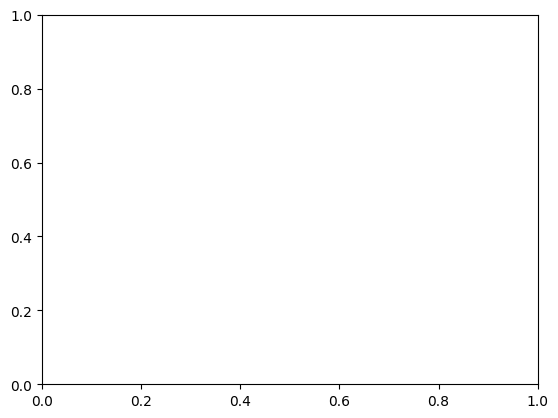

In [14]:
file = "AC_dataset.csv"

Training_Set, Testing_Set          = Train_Test_Split(file)                                 #Create training and testing sets
IT_list, LT_list, IV_list, LV_list = CV(Training_Set) 

viz(Training_Set)

## Balancing (inner loop)

In [ ]:
def find_minority_class(classData):
    """ 
    Input:        classData  Array of class labels

    Returns:      minClass   The label for the minority class
                  minSize    The number of items in the minority class
                  maxSize    The number of items in the majority class

    Find information about class size imbalance
    """
    
    Minority_count = 0
    Majority_count = 0
    for datum in classData:
        if datum == 1:
            Majority_count += 1
        elif datum == 0:
            Minority_count += 1

    minClass = 0
    minSize  = Minority_count
    maxSize  = Majority_count
    if Minority_count > Majority_count:
        minClass = 1
        minSize  = Majority_count
        maxSize  = Minority_count

    return minClass, minSize, maxSize

In [ ]:
def balance(inData, classData, minClass, minSize):
    """ 
    Input:        inData          array of input data
                  classData       array of classes assigned
                  minorityClass   class label for the minority class
                  minoritySize    size of the minority class

    Returns:      array of indexes that are of interest for a balanced dataset

    Perform the actual balancing for a fold between SNPs and PDs
    """
    usedLines = [False] * len(inData) #Array of false for length of data
    for i in range(len(inData)):
        if classData.array[i] == minClass:
            usedLines[i] = True
            
    usedCount = 0
    while usedCount < minSize:
        i = rd.randrange(len(inData))
        if usedLines[i] == False:
            usedCount += 1
            usedLines[i] = True       

    return usedLines

In [ ]:
def balance_data(inData, classData, usedLines):
    """     
    Input:      inData      array of input training data
                classData   array of classes assigned to training data
                usedLines   array of line indexes to print

    Returns:    input_balance  Dataframe of balanced training features
                label_balance  Dataframe of balanced training labels
                       
    Create dataframe of the input training data and classes used. The index [i] is the identifier between the two arrays.
    """
    input_balance = []
    label_balance = []
    
    for i in range(len(inData)):
        if usedLines[i] == True:
            input_i = inData.iloc[i]
            input_balance.append(input_i)
            
            label_i = classData.iloc[i]
            label_balance.append(label_i)
    
    return input_balance, label_balance

### Balance for n folds

In [ ]:
def Balance_ratio(maxSize, minSize): 
    """ 
    Input:      maxSize     The number of items in the majority class
                minSize     The number of items in the minority class

    Returns:    BF          Number of balancing folds

    Calculate the number of balancing folds needed using ratio of majority to minority class size. Double to ensure sufficient
    majority class instances are sampled, then + 1 to make odd to allow weighted vote.
    """
    Divide = maxSize/minSize
    BF = (2 * round(Divide)) + 1 #Double ratio to nearest integer
    return BF

In [ ]:
def Balance_Folds(BF, inData, classData, minClass, minSize):
    """ 
    Input:      BF                Number of balancing folds
                usedLines         Array of line indices to use
                input_balance     Dataframe of balanced training features
                label_balance     Dataframe of balanced training labels
                    
    Returns:    Input_folds       List of balanced training feature folds
                Output_folds      List of balanced training label folds

    Perform the balance_data() function n number of balancing fold times. Return lists for feature data and labels
    where each item is the output of balance_data()
    """
    Input_folds  = []
    Output_folds = []

    for i in range(BF):
        usedLines                    = balance(inData, classData, minClass, minSize)
        input_balance, label_balance = balance_data(inData, classData, usedLines)
        
        Input_folds.append(input_balance)
        Output_folds.append(label_balance)
            
    return Input_folds, Output_folds

### RFC hyperparameter tuning

In [ ]:
# def Hyperparameter(BF, Input_folds, Output_folds):
#     """ Input:      BF                Number of balancing folds needed
#                     Input_folds       List of 5 balanced arrays of training data
#                     Output_folds      List of 5 balanced arrays of training data's labels

#         Returns:    BF_RFC_HP         List of optimized hyperparameters for each RFC

#         Perform RandomSearchCV on each RFC to optimize number of trees, max depth and max samples
#     """  
#     estimator = RandomForestClassifier()
#     param_grid = {
#                 'n_estimators':np.arange(50,500,50),
#                 'max_depth': np.arange(2, 10, 2),
#                 'max_samples': np.arange(0.2, 1.2, 0.2)
#                   }
#     BF_RFC_HP = []

#     for i in range(BF):
#         HPtuning = RandomizedSearchCV(
#             estimator,
#             param_grid, 
#             scoring = 'balanced_accuracy',
#             cv = 10,
#             n_jobs = 6, #how many cores to run in parallel
#             verbose = 2
#             ).fit(Input_folds[i], Output_folds[i])
#         BF_RFC_HP.append(HPtuning.best_params_)
    
#     return(BF_RFC_HP)

### Train RFC on the trainings folds

In [ ]:
def BF_fitting(BF, Input_folds, Output_folds): 
    """ 
    Input:      BF                Number of balancing folds                      
                Input_folds       List of balanced training feature folds
                Output_folds      List of balanced training label folds

    Returns:    BF_RFC            List of RFCs trained on each balancing fold

    Create RFC model that returns probability predictions for each fold, using output of Balance_Folds() as training data
    """    
    BF_RFC = []
    for i in range(BF):
        BF_RFC.append(RandomForestClassifier(verbose = 0)) #Generates a RFC for each fold's training data
        BF_RFC[i].fit(Input_folds[i], Output_folds[i])     #Fits the RFC to each folds' training data
        
    return BF_RFC

#### Validate each RFC on validation set, for each fold

In [ ]:
def BF_validate(BF_RFC, ValData):
    """ 
    Input:      BF_RFC          List of RFCs trained on balancing folds
                ValData         Unseen validation features from CV fold
                
    Returns:    Prob_matrix     List of arrays. Each item is 2D matrix where the 1st dimension is each subset in balancing fold, 
                                2nd dimension is predicted probability
    
    Test the trained RFCs on the test set, then for every instance, outputs the predicted probability for each class
    """
    
    Prob_matrix = []
    
    for i in range(len(BF_RFC)):
        Prob = BF_RFC[i].predict_proba(ValData.values) #Predicts the probability of an instance belonging to major or minor class
        Prob_matrix.append(Prob)   
        
    return Prob_matrix

### Weighted voting

In [ ]:
def Weighted_Vote(Prob_matrix):
    """ 
    Input:      Prob_matrix     List of arrays. 2D matrix where the 1st dimension is each subset in balancing fold, 
                                2nd dimension is predicted probability

    Returns:    Final_vote      Weighted vote classification

    Calculate the final weighted vote using confidence scores (Sc) from Prob_matrix. Binary classification formula:
    Sc = (S0 -T)/(1-T) if S0> T
    Sc = (T-S0)/T if S0 < T
    """
    # for fold in range(len(Prob_matrix)):      #Calculates SNP Sc all instances in each fold
    #     Sc_SNP = []
    #     Sc_PD = []
    #     for i in range(len(Prob_matrix)):
    #         Sc_SNP.append(Prob_matrix[i][:,0])
    #         Sc_PD.append(Prob_matrix[i][:,1])
    
    T = 0.45                                    #Lower threshold gives more sensitivity to PDs over SNPs
    Sc_SNP = []
    Sc_PD = []

    for fold in range(len(Prob_matrix)):        #Calculates SNP Sc all instances in each fold

        Sc_SNP_fold = []                        #List of the Sc for each fold
        for value in range(len(Prob_matrix[fold][:,0])):
            S0 = Prob_matrix[fold][:,0][value]  #Each SNP's confidence in prob matrix fold
            if S0 < T:
                Sc = (T - S0)/T
            elif S0 >= T:
                Sc = (S0 - T)/(1 - T)        
            Sc_SNP_fold.append(Sc)              #List of Sc for each fold
        Sc_SNP.append(Sc_SNP_fold)              #List of folds with Sc

    for fold in range(len(Prob_matrix)):        #Calculates PD Sc all instances in each fold
        Sc_PD_fold = []
        for value in range(len(Prob_matrix[fold][:,1])):
            S0 = Prob_matrix[fold][:,1][value]  #Each PD's confidence in prob matrix fold
            if S0 < T:
                Sc = (T - S0)/T
            elif S0 >= T:
                Sc = (S0 - T)/(1 - T)        
            Sc_PD_fold.append(Sc)
        Sc_PD.append(Sc_PD_fold)
        
    columnSNP = np.stack(Sc_SNP)                #Covert list of lists to array, shape (5,~539)
    columnPD  = np.stack(Sc_PD)

    Sum_SNP   = np.sum(columnSNP, axis = 0)     #Sum of all SNP confidence scores. 1D Array
    Sum_PD    = np.sum(columnPD, axis = 0)      #Sum of all PD confidence scores. 1D Array
    
    
    Vote_arr  = [] 

    for i in range(len(Sum_PD)):
        if Sum_PD[i] >= Sum_SNP[i]:
            Vote_arr.append([1])                #Append PD classifications to list
        elif Sum_SNP[i] > Sum_PD[i]:
            Vote_arr.append([0])                #Append SNP classifications to list

    Final_vote = np.stack(Vote_arr)             #Converts list of arrays to a 2D array
    Final_vote = Final_vote.ravel()             #Flattens 2D array to 1D array

    return(Final_vote, Sum_PD, Sum_SNP)         #Returns the final confidence scores


## Final confidence

In [ ]:
# def Final_score(Sum_PD, Sum_SNP, BF):
#     """ 
#     Input:      Sum_PD      Sum of confidence score for PD predictions
#                 Sum_SNP     Sum of confidence score for SNP predictions

#     Returns:    S_out       Final confidence score

#     Calculate the final confidence score
#     """
    
#     S_Out = np.abs((Sum_PD - Sum_SNP) /(BF*2))
        
#     return S_Out

In [ ]:
def evalutation(Vallabel, Final_vote):
    """ 
    Input:      Vallabel           Unseen validation class labels from CV fold
                Final_vote         Weighted vote classification

    Evaluate each fold with confusion matrix and MCC
    """
    Output_pred = Final_vote
    print(f"-----------------------------------------------------\n              ***Fold {folds + 1} Evaluation***\n")
    print(f"Confusion Matrix:\n {confusion_matrix(Vallabel, Output_pred)}")
    print(f"{classification_report(Vallabel, Output_pred)}\nMCC                {matthews_corrcoef(Vallabel, Output_pred)}\n")

### Main Program

In [ ]:
file = "AC_dataset.csv"

Training_Set, Testing_Set          = Train_Test_Split(file)                                 #Create training and testing sets
test(Training_Set, Testing_Set)                                                             #Initial evaluation
IT_list, LT_list, IV_list, LV_list = CV(Training_Set)                                       #Cross-validate training set

for folds in range(len(IT_list)):                                                       
    classData                   = LT_list[folds]                                            #Training labels
    inData                      = IT_list[folds]                                            #Training features
    ValData                     = IV_list[folds]                                            #Validation features
    Vallabel                    = LV_list[folds]                                            #Validation labels

    minClass, minSize, maxSize  = find_minority_class(classData)                            #Determines imbalance
    BF                          = Balance_ratio(maxSize, minSize)                           #Determins number of balancing folds needed
    Input_folds, Output_folds   = Balance_Folds(BF, inData, classData, minClass, minSize)   # balance() and balance_data() functions are called under this
    # BF_RFC_HP = Hyperparameter(BF, Input_folds, Output_folds)
    BF_RFC                      = BF_fitting(BF, Input_folds, Output_folds)
    Prob_matrix                 = BF_validate(BF_RFC, ValData)

    Final_vote, Sum_PD, Sum_SNP = Weighted_Vote(Prob_matrix)
    # S_Out                       = Final_score(Sum_PD, Sum_SNP, BF)

    evalutation(Vallabel, Final_vote)